We have recorded data when the car took full circles in the parking lot. There are two circles, one of those should be processed. 

The recorded data can be downloaded from the following link: 

<a href="https://ikelte-my.sharepoint.com/personal/kovbando_inf_elte_hu/_layouts/15/onedrive.aspx?id=%2Fpersonal%2Fkovbando%5Finf%5Felte%5Fhu%2FDocuments%2Fosszerendelt%5Fnyers%5Fadatok%2F20240628&ga=1">20240628</a>

GPS data is given in the CSB file. The lateral (lat) and longitudinal (lon) coordinates can be read from the corresponding columns.  

 

The task is to automatically and robustly segment the points corresponding to one of the turning circles and then to estimate the radius of the circle. 

 

Conversion of GPS lat/lon coordinates to spatial locations: 

x = R * cos(lat) * cos(lon) 
y = R * cos(lat) * sin(lon) 
z = R *sin(lat) 

Where R=6.371.000m (radius of Earth) 

Remark that the altitude is static, therefore it is not included in the formulas. 

 

Scoring: 

Data loading (2 points) and conversion (2 points) of GPS locations to spatial coordinates are the initial tasks. 

Project the 3D points onto the plane of the ground plane to obtain 2D coordinates (2 points). 

The implementation for RANSAC algorithm itself costs  4 points, that for circle estimation is another  4 points.  

If the radius is estimated from all the inliers, you get more 3 points. 

Until this point, the process should be fully automatic, no manual intervention is allowed. 

 

Finally, save the results in xyz format (2 points), then visualize the selected inliers (1 points) in Meshlab. 

#### Data Loading

In [ ]:
# Import Necessary Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as Rot
from numpy.linalg import norm
from sklearn.linear_model import RANSACRegressor
from sklearn.base import BaseEstimator, RegressorMixin
from numpy.linalg import norm
from matplotlib.patches import Circle
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load the CSV file
df = pd.read_csv("fordulokor.csv", delimiter=';')

# Display the column names
print("Columns:", df.columns)

# Extract latitude and longitude values
lat = df['Lat'].values
lon = df['Lon'].values

Columns: Index(['ID', 'Lat', 'Lon', 'Alt', 'Vel', 'Ax', 'Ay', 'Az', 'Mx', 'My', 'Mz'], dtype='object')


#### GPS Locations to Spatial Coordinates

In [114]:
# Radius of Earth (in meters)
R_earth = 6371000

# Convert GPS coordinates to 3D spatial coordinates
def gps_to_spatial(lat, lon):
    lat_rad = np.radians(lat)
    lon_rad = np.radians(lon)
    
    x = R_earth * np.cos(lat_rad) * np.cos(lon_rad)
    y = R_earth * np.cos(lat_rad) * np.sin(lon_rad)
    z = R_earth * np.sin(lat_rad)
    
    return np.vstack((x, y, z)).T

points_3D = gps_to_spatial(lat, lon)

# Display the first few points
print(points_3D[:5])


[[4070215.47059326 1406522.67004136 4695176.35468605]
 [4070215.46971152 1406522.66841131 4695176.35593873]
 [4070215.46971152 1406522.66841131 4695176.35593873]
 [4070215.46942928 1406522.67759131 4695176.35343337]
 [4070215.47201102 1406522.67848347 4695176.35092802]]


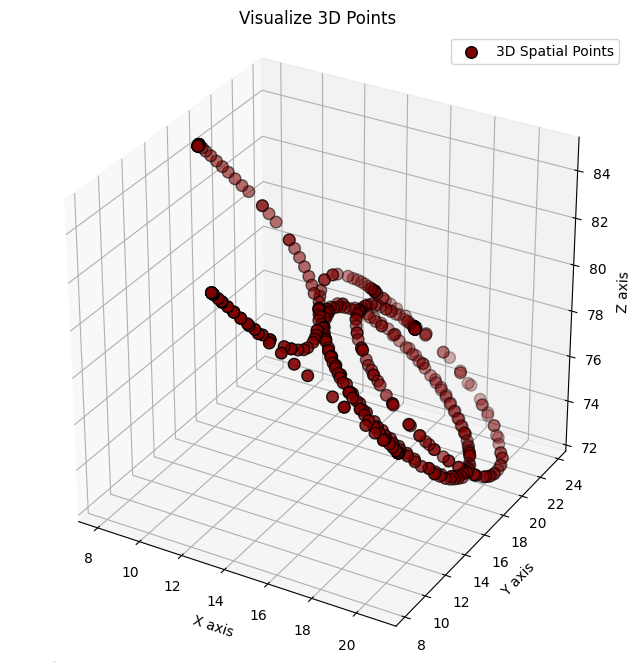

In [115]:

# Plotting 3D points
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points_3D[:, 0], points_3D[:, 1], points_3D[:, 2], color='maroon', edgecolor='black', s=70, label="3D Spatial Points")
# Set labels and title
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.set_title("Visualize 3D Points")
# Set equal aspect ratio for all axes to avoid scaling issues
ax.set_box_aspect([1, 1, 1])
plt.legend()
# Show the plot 
plt.show()


#### Project the 3D points onto the plane of the ground plane to obtain 2D coordinates 

The local East, North, Up (ENU) Cartesian coordinate system is formed from a plane tangent to the Earth's surface fixed to a specific location and hence it is sometimes known as a "Local Tangent" or "Local Geodetic" plane.

<img src="ENU.png" alt="" width="600"/>

Here, the larger sphere represents the Earth, typically shown in the ECEF (Earth-Centered, Earth-Fixed) coordinate system. At a specific point on the Earth's surface, there is a small plane representing the local ENU coordinate system. The two primary angles involved are latitude (φ) and longitude (λ), which define the position on the Earth’s surface.

<p style="color:red;">For projecting 3D points onto a 2D plane, I followed the Local ENU Cartesian Coordinate System.</p>

<img src="Ecef_coordinates.png" alt="" width="600"/>





For any given location on Earth, defined by latitude (φ) and longitude (λ), we can establish the ENU (East-North-Up) coordinate system as follows:

<p style="color:blue;">East Vector (E):</p>
The East vector points towards increasing longitude and is orthogonal to the Up vector.
Defined as:

E = [-sin(λ), cos(λ), 0]

 where:

- λ is the longitude of the reference point.
- φ is the latitude of the reference point.
- sin(λ) and cos(λ) represent determine the direction of the East vector in the ECEF coordinates when moving eastward.

 <p style="color:blue;">North Vector (N):</p>
 The North vector points towards increasing latitude and is orthogonal to both the East and Up vectors.
 Defined as:
 
N = [-sin(φ) * cos(λ), -sin(φ) * sin(λ), cos(φ)]


where:
- φ is the latitude of the reference point.
- λ is the longitude of the reference point.
- cos(λ) and sin(𝜆) adjust the components of the North vector in the ECEF coordinate frame, combining eastward and northward components.
- sin(ϕ) and cos(𝜙) adjust the direction of the North vector to align with changes in latitude.



 <p style="color:blue;">Up Vector (U)</p>
The Up vector points radially away from the Earth's surface, perpendicular to the tangent plane.
Defined as: 

U = [cos(φ) * cos(λ), cos(φ) * sin(λ), sin(φ)]

where:
- ϕ is the latitude of the reference point.
- λ is the longitude of the reference point.
- cos(𝜙) cos(ϕ) and sin(𝜙) sin(ϕ) determine the Up vector's components aligned with changes in the upward direction from the Earth's surface.
- cos(𝜆) cos(λ) and sin(𝜆) sin(λ) adjust the eastward and northward components of the Up vector in the ECEF coordinates, pointing directly away from the Earth's center at the specified latitude and longitude.


<p style="color:gray;">Since projecting onto a 2D plane, we do not need the Up component (which would be the Z-coordinate in ENU). We only use the East (E) and North (N) components.</p>

 <p style="color:blue;">Projecting 3D ECEF Points onto the 2D ENU Plane: </p>
<p style="color:maroon;">1. Translate the ECEF Point to the Local Origin </p>

 Define a reference point in ECEF coordinates as the origin of the ENU system.

 Let `P_ref` be the reference point in ECEF coordinates. For a given ECEF point `P_ECEF`, calculate the translated point:

P_local = P_ECEF - P_ref

This step moves the ECEF point to the origin of the ENU system, creating a vector `P_local` that represents the point relative to the ENU origin.

<p style="color:maroon;">2. Project onto the ENU coordinates </p>

Project the translated point `P_local` onto the East and North vectors to get the 2D coordinates in the ENU plane.

- **x: Coordinate along the East direction**
x = P_local.E 
= (P_local)_x * E_x + (P_local)_y * E_y + (P_local)_z * E_z

where, (P_local)_x, (P_local)_y, and (P_local)_z are the components of `P_local` in the X, Y, and Z directions of ECEF, respectively.

- (E_x, E_y, E_z) are the components of the East vector.

 - **y: Coordinate along the North direction**

  y = P_local . N 
  = (P_local)_x * N_x + (P_local)_y * N_y + (P_local)_z * N_z
  
 where, (N_x, N_y, N_z) are the components of the North vector.


The resulting (x, y) coordinates represent the position of the point in the 2D ENU plane, effectively mapping the 3D ECEF point onto a local tangent plane.



<p style="color:green;"> Source from <a href="https://en.m.wikipedia.org/wiki/Local_tangent_plane_coordinates" style="color:skyblue;">here</a></p>



In [116]:
# Fix one point as the origin of the tangent plane (reference point)
lat_ref = lat[1]  # Select the latitude of the reference point from an array of latitudes
lon_ref = lon[1]  # Select the longitude of the reference point from an array of longitudes

#Convert the reference point's latitude and longitude to spatial coordinates
x_ref, y_ref, z_ref = gps_to_spatial(lat_ref, lon_ref)[0]
ref_point = np.array([x_ref, y_ref, z_ref])

# Calculate unit vectors for the local tangent plane (East, North, Up)
lat_ref_rad = np.radians(lat_ref)
lon_ref_rad = np.radians(lon_ref)
# East vector: perpendicular to North and Up, pointing towards increasing longitude
east_norm = np.array([-np.sin(lon_ref_rad), np.cos(lon_ref_rad), 0])


# North vector: perpendicular to East and Up, pointing towards increasing latitude
north_norm = np.array([
    -np.sin(lat_ref_rad) * np.cos(lon_ref_rad),  
    -np.sin(lat_ref_rad) * np.sin(lon_ref_rad), 
    np.cos(lat_ref_rad)                         
])


# Up vector: perpendicular to the tangent plane, pointing outward from the Earth's surface
up = np.array([
    np.cos(lat_ref_rad) * np.cos(lon_ref_rad), 
    np.cos(lat_ref_rad) * np.sin(lon_ref_rad),  
    np.sin(lat_ref_rad)                         
])


# Project each 3D point onto the tangent plane (East-North plane)
def project_to_tangent_plane(point, ref_point, east, north):
    # Calculate the vector from the reference point to the current point
    vec = point - ref_point
    # Project the vector onto the East direction
    x_2d = np.dot(vec, east)
     # Project the vector onto the North direction
    y_2d = np.dot(vec, north)
    
    return np.array([x_2d, y_2d])

# Apply the projection for all points
points_2D = np.array([project_to_tangent_plane(point, ref_point, east_norm, north_norm) for point in points_3D])



Filtering the 2D points as merging the points which are close to each other. This method is commonly known as <p style="color:white;"> proximity-based merging or distance-based deduplication. </p>



In [117]:
def merge_close_points(points, threshold):
    merged_points = []  # List to store the merged points
    for point in points:
        found = False  # Flag to indicate if a close point was found
        
        # Check if the current point is close to any already merged point
        for i, existing in enumerate(merged_points):
            # Calculate the Euclidean distance between the current point and an existing merged point
            if np.linalg.norm(point - existing) < threshold:
                # If the points are close, merge by averaging their coordinates
                merged_points[i] = (merged_points[i] + point) / 2
                found = True
                break
        
        # If no close point was found, add the current point as a new merged point
        if not found:
            merged_points.append(point)
    
    return np.array(merged_points)


merged_points_2D = merge_close_points(points_2D, threshold=0.4)


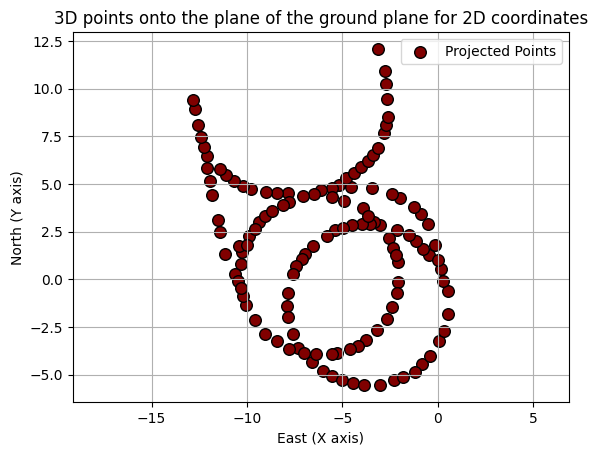

In [118]:

# Update the 2D points 
points_2D=merged_points_2D

# Plot the 2D projected points
plt.figure()
plt.scatter(points_2D[:, 0], points_2D[:, 1], color='maroon', edgecolor='black', s=70, label='Projected Points')
plt.xlabel('East (X axis)')
plt.ylabel('North (Y axis)')
plt.title('3D points onto the plane of the ground plane for 2D coordinates')
plt.axis('equal')
plt.legend()
plt.grid(True)

# Save the plot as an image file
plt.savefig("projected_3d_to_2d.png", dpi=300)
plt.show()

#### The implementation for RANSAC algorithm itself costs that for circle estimation .  
#### The radius is estimated from all the inliers.
##### Save the results in xyz format

 <p style="color:red;">Ransac Algorithm Steps</p>
 
 - Step 1:Randomly select a subset of points from the sample_size.

 - Step 2: Use the selected points to fit the circle model parameters (For circle with 3 points).
   
 - Step 3: For each point in the dataset, calculate its distance from the model. If this distance is below the inlier_threshold, classify it as an inlier.

 - Step 4: If the current model has more inliers than the best model so far:

           - Update Optimal Model with the current model’s parameters.

           - Update Optimal Inliers with the current set of inliers.

           - Update highest_inlier_count to reflect the number of inliers found.

- Step 5:  Calculate Required Iterations for Confidence:

           - Calculate the outlier ratio based on the number of inliers.

           - Estimate the required number of iterations needed to reach the target confidence using:

               required_iterations = log(1 - target_confidence) / log(1 - (1 - outlier_ratio) ** sample_size)

                 where:

                        - target_confidence: The desired probability of finding the best-fit model.

                        - outlier_ratio: The estimated proportion of outliers in the data.
                        
                        - sample_size: The minimum number of points required to fit the model. 


           - If the current iteration count meets or exceeds required_iterations, stop early.

- Step 6: Once the maximum number of iterations or the confidence level is reached, return:

            - The parameters of the best-fit model (circle center and radius).

            - The list of inliers associated with this model.




Best Circle Center: [-3.66537088 -1.31800649]
Number of Inliers: 43
Best Radius (RANSAC Radius): 4.212868802522614
Refined Radius (estimated from all inliers): 4.225252722978319


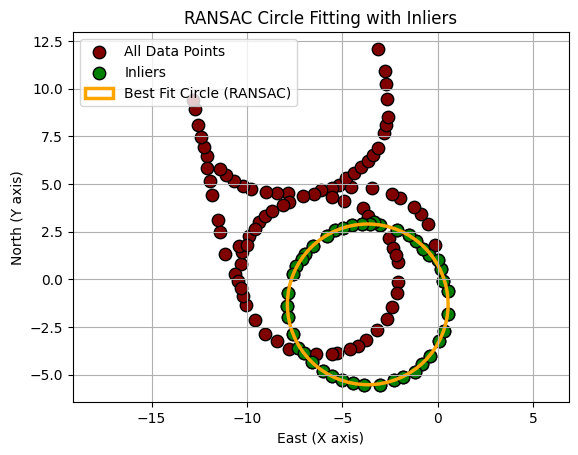

Results saved in 'circle_inliers.xyz'.


In [122]:

from numpy.linalg import norm
import math
""""""""""""""""""""""""""""""""""""""""""""""""""" Circle Fitting """""""""""""""""""""""""""""""""""""""""""""""
class CircleFittingModel:
    """
    CircleFittingModel class for fitting a circle to a given set of 2D points using least squares.
    The circle equation is given by: (x - x0)^2 + (y - y0)^2 = R^2
    where (x0, y0) is the center of the circle and R is its radius.
    
    This implicit equation can be rearranged for fitting purposes as:
    x^2 - 2*x0*x + x0^2 + y^2 - 2*y0*y + y0^2 - R^2 = 0.
    
    Using multiple points, construct a system of equations and solve for x0, y0, and R.
    
    """
    
    def fit(self, sample_points):
        # Set up the linear system to solve for circle parameters
        sample_points = np.array(sample_points)
        
        # Matrix A: coefficients for the least-squares problem
        matrix_A = np.column_stack((np.ones(sample_points.shape[0]), -2 * sample_points[:, 0], -2 * sample_points[:, 1]))
        
        # Matrix B: constants based on x^2 + y^2
        matrix_B = -(sample_points[:, 0]**2 + sample_points[:, 1]**2)
        
        # Solve for circle parameters using least squares
        parameters, _, _, _ = np.linalg.lstsq(matrix_A, matrix_B, rcond=None)
        
         # Extracting constant and center coordinates
        constant, center_x, center_y = parameters
        
        # Calculate center and radius from parameters
        circle_center = np.array([center_x, center_y])
        circle_radius = np.sqrt(center_x**2 + center_y**2 - constant)
        
        return circle_center, circle_radius

""""""""""""""""""""""""""""""""""""""""""""""""""" Ransac Agorithm """""""""""""""""""""""""""""""""""""""""""""""""""""
class RANSACAlgorithm:
 
    def __init__(self, model):
        # The model to be used for fitting
        self.model = model
    
    def fit(self, data_points, sample_size, inlier_threshold):
        # Initial settings for RANSAC iterations and thresholds
        
        required_iterations = math.inf # To determine number of iterations adaptively
        iteration_count = 0 #Current iterations count

        highest_inlier_count = 0 # Track highest number of inliers found
        optimal_circle = None # Store optimal circle parameters
        optimal_inliers = [] # Store inliers for the optimal circle

        outlier_probability = 0.3  # Initial outlier probability
        target_confidence = 0.95 # Desired confidence level (95%)
                  
        total_data_points = len(data_points)

        # Adaptive iteration count determination
        while required_iterations > iteration_count:
            
            # Randomly sample points
            sample_points = data_points[np.random.choice(data_points.shape[0], sample_size, replace=False), :]
            
            # Estimate circle parameters
            center, radius = self.model.fit(sample_points)
            
            if center is None:
                continue  # Skip if circle fitting failed

            # Calculate inliers based on threshold
            inliers = []
            for point in data_points:
                # Calculate the distance of the point from the estimated center
                distance_from_center = np.linalg.norm(point - center)
                # Check if the point lies within the inlier threshold range of the circle's radius point is considered an inlier
                if abs(distance_from_center - radius) < inlier_threshold: 
                    inliers.append(point)
                    
         
            # Check if the current model is better (more inliers than previous models)
            if len(inliers) > highest_inlier_count:
                highest_inlier_count = len(inliers) # Update the count of inliers
                optimal_circle = (center, radius) # Update the optimal circle parameters
                optimal_inliers = inliers# Update the set of inliers for the optimal circle
                
            # Update outlier probability based on the current best inlier count
            outlier_probability = 1 - highest_inlier_count / total_data_points
            # Calculate the required number of iterations to achieve the target confidence level
            required_iterations = math.log(1 - target_confidence) / math.log(1 - (1 - outlier_probability) ** sample_size)
            # Increment the iteration count
            iteration_count += 1

        return optimal_circle, np.array(optimal_inliers)


# Initialize and run RANSAC with CircleFittingModel
circle_model = CircleFittingModel()
ransac = RANSACAlgorithm(circle_model)
best_fit_circle, circle_inliers = ransac.fit(points_2D, sample_size=3, inlier_threshold=0.2)

# Plotting the results if a valid circle was found
if best_fit_circle:
    circle_center, best_fit_radius = best_fit_circle
    print(f"Best Circle Center: {circle_center}")
    print(f"Number of Inliers: {len(circle_inliers)}")
    print("Best Radius (RANSAC Radius):", best_fit_radius)
   
    """"""""""""""""""""" The radius is estimated from all the inliers """""""""""""""""""""""""""""
    # Refined radius estimated from all inliers
    refined_radius = np.mean([np.linalg.norm(point - circle_center) for point in circle_inliers])
    print("Refined Radius (estimated from all inliers):", refined_radius)
    
    """"""""""""""""""""""""""""""" Visualize the Best Fitted Cirle """""""""""""""""""""""""""""""
    # Plot using Circle patch
    fig, ax = plt.subplots()
    ax.scatter(points_2D[:, 0], points_2D[:, 1], color='maroon', edgecolor='black', s=80, label='All Data Points')
    ax.scatter(circle_inliers[:, 0], circle_inliers[:, 1], color='green', edgecolor='black', s=80, label='Inliers')
    
    # Add Circle patch for best-fit circle
    circle_patch = Circle(circle_center, best_fit_radius, color='orange', fill=False, linewidth=2.5, label='Best Fit Circle (RANSAC)')
    ax.add_patch(circle_patch)

    ax.set_xlabel('East (X axis)')
    ax.set_ylabel('North (Y axis)')
    ax.set_title('RANSAC Circle Fitting with Inliers')
    ax.legend()
    ax.axis('equal')
    ax.grid(True)
    plt.savefig("ransac_circle_fitting.png", dpi=300)
    plt.show()
else:
    print("RANSAC did not find a valid circle.")
    
""""""""""""""""""""""""""""""""""""""""""""" Save the results in xyz format """""""""""""""""""""""""""""""""""""""""""""""
# Save circle parameters and inliers to XYZ files
def save_points_to_xyz(filename,inliers):
    with open(filename, "w") as file:
        # Save each inlier point
        for point in inliers:
            file.write(f"{point[0]} {point[1]} 0.0\n")

# Define circle center and a circumference point
circumference_point = circle_center + np.array([refined_radius, 0])  # Point on the circle circumference along x-axis

save_points_to_xyz("circle_inliers.xyz", circle_inliers)

print("Results saved in 'circle_inliers.xyz'.")
